In [2]:
!pip install evaluate
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments
import evaluate
import torch
import pandas as pd
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
import pandas as pd
# Read csv and target the text for preprocessing
df_train = pd.read_csv("trac2_CONVT_train.csv")
columnsTrain = df_train["text"]
listSentence = []
for column in columnsTrain:
    listSentence.append(column)


In [9]:
batch = tokenizer(listSentence, padding=True, truncation=True, return_tensors="pt")
print(batch["input_ids"])
print(batch["attention_mask"])

tensor([[ 101, 2054, 2106,  ...,    0,    0,    0],
        [ 101, 2009, 1005,  ...,    0,    0,    0],
        [ 101, 1045, 2228,  ...,    0,    0,    0],
        ...,
        [ 101, 2030, 2002,  ...,    0,    0,    0],
        [ 101, 1045, 2123,  ...,    0,    0,    0],
        [ 101, 7929, 4067,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [31]:
def build_label(df):
  labels_class = torch.tensor(df["EmotionalPolarity"].values,  dtype=torch.int64)
  labels_intensity = torch.tensor(df["Emotion"].values, dtype=torch.float)
  labels_empathy = torch.tensor(df["Empathy"].values, dtype=torch.float)
  return labels_class, labels_intensity, labels_empathy

In [11]:
from datasets import Dataset

labels_class, labels_intensity, labels_empathy = build_label(df_train)
hf_dataset = Dataset.from_dict({
    "input_ids": batch["input_ids"],
    "attention_mask": batch["attention_mask"],
    "labels_class": labels_class,
    "labels_intensity": labels_intensity,
    "labels_empathy": labels_empathy
})

In [12]:
hf_dataset = hf_dataset.train_test_split(test_size=0.2)
train_dataset = hf_dataset["train"]
val_dataset = hf_dataset["test"]

In [13]:
from transformers import BertModel, BertPreTrainedModel
import torch
from torch import nn

class BertMultiTask(BertPreTrainedModel):
    def __init__(self, config, num_labels=3):
        super().__init__(config)
        self.bert = BertModel(config)
        hidden = config.hidden_size
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden, num_labels)
        self.reg1 = nn.Linear(hidden, 1)
        self.reg2 = nn.Linear(hidden, 1)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None,
                labels_class=None, labels_intensity=None, labels_empathy=None):
        out = self.bert(input_ids, attention_mask=attention_mask)
        pooled = self.dropout(out.pooler_output)
        logits = self.classifier(pooled)
        r1 = self.reg1(pooled).squeeze(-1)
        r2 = self.reg2(pooled).squeeze(-1)

        loss = None
        if labels_class is not None:
            loss_fct_cls = nn.CrossEntropyLoss()
            loss_fct_reg = nn.MSELoss()
            loss = (
                loss_fct_cls(logits, labels_class)
                + loss_fct_reg(r1, labels_intensity)
                + loss_fct_reg(r2, labels_empathy)
            )
        return {"loss": loss, "logits_cls": logits, "reg1": r1, "reg2": r2}


In [14]:
from transformers import BertModel, BertPreTrainedModel
import torch
from torch import nn

class BertMultiTask(BertPreTrainedModel):
    def __init__(self, config, num_labels=3):
        super().__init__(config)
        self.bert = BertModel(config)
        hidden = config.hidden_size
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden, num_labels)
        self.reg1 = nn.Linear(hidden, 1)
        self.reg2 = nn.Linear(hidden, 1)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None,
                labels_class=None, labels_intensity=None, labels_empathy=None):
        out = self.bert(input_ids, attention_mask=attention_mask)
        pooled = self.dropout(out.pooler_output)

        logits = self.classifier(pooled)
        probs_cls = torch.softmax(logits, dim=-1)

        r1 = self.reg1(pooled).squeeze(-1)
        r2 = self.reg2(pooled).squeeze(-1)

        loss = None
        if labels_class is not None:
            loss_fct_cls = nn.CrossEntropyLoss()
            loss_fct_reg = nn.MSELoss()
            loss = (
                loss_fct_cls(logits, labels_class)
                + loss_fct_reg(r1, labels_intensity)
                + loss_fct_reg(r2, labels_empathy)
            )
        return {"loss": loss, "logits_cls": logits, "reg1": r1, "reg2": r2}


In [15]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained("bert-base-uncased")
model = BertMultiTask.from_pretrained("bert-base-uncased", config=config, num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertMultiTask were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'reg1.bias', 'reg1.weight', 'reg2.bias', 'reg2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import numpy as np
import evaluate

acc_metric = evaluate.load("accuracy")
mse_metric = evaluate.load("mse")


def compute_metrics(eval_pred):

    logits_cls, r1, r2 = eval_pred.predictions

    labels_cls, labels_r1, labels_r2 = eval_pred.label_ids

    preds_cls = np.argmax(logits_cls, axis=1)

    acc  = acc_metric.compute(predictions=preds_cls, references=labels_cls)
    mse1 = mse_metric.compute(predictions=r1, references=labels_r1)
    mse2 = mse_metric.compute(predictions=r2, references=labels_r2)

    return {
        "accuracy": acc["accuracy"],
        "mse_intensity": mse1["mse"],
        "mse_empathy": mse2["mse"]
    }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [17]:
import transformers
print(transformers.__version__)

4.57.1


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert-multitask-results",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    weight_decay=0.01,

    eval_strategy="steps",
    save_strategy="epoch",
    eval_steps=50,
    logging_dir="./logs",
)


In [19]:
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-1203300166.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()
trainer.save_model("./bert-multitask-final")
tokenizer.save_pretrained("./bert-multitask-final")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xtran2 (xtran2-university-of-illinois-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Mse Intensity,Mse Empathy
50,No log,1.965638,0.621731,0.452187,0.600248
100,No log,1.722838,0.645627,0.386814,0.545236
150,No log,1.611193,0.676285,0.374292,0.515913
200,No log,1.605286,0.688007,0.387442,0.528211
250,No log,1.556826,0.702435,0.370833,0.521238
300,No log,1.576858,0.723625,0.361478,0.570261
350,No log,1.519633,0.722723,0.367665,0.511038
400,No log,1.495683,0.727683,0.362562,0.501527
450,No log,1.490702,0.728584,0.347996,0.513101
500,1.753400,1.483910,0.728584,0.348861,0.505027


('./bert-multitask-final/tokenizer_config.json',
 './bert-multitask-final/special_tokens_map.json',
 './bert-multitask-final/vocab.txt',
 './bert-multitask-final/added_tokens.json',
 './bert-multitask-final/tokenizer.json')

In [58]:
df_test = pd.read_csv("trac2_CONVT_dev.csv")
df_test["EmotionalPolarity"] = np.ceil(df_test['EmotionalPolarity'])

columnsTest = df_test["text"]
listSentenceTest = []
ids = df_test["id"].tolist()
for column in columnsTest:
    listSentenceTest.append(column)

In [34]:
batchTest = tokenizer(listSentenceTest, padding=True, truncation=True, return_tensors="pt")
print(batchTest["input_ids"])
print(batchTest["attention_mask"])
labels_class, labels_intensity, labels_empathy = build_label(df_test)

tensor([[ 101, 7592, 2129,  ...,    0,    0,    0],
        [ 101, 7592,  999,  ...,    0,    0,    0],
        [ 101, 1045, 1005,  ...,    0,    0,    0],
        ...,
        [ 101, 6343, 2323,  ...,    0,    0,    0],
        [ 101, 1045, 3246,  ...,    0,    0,    0],
        [ 101, 3398, 1010,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [35]:
from datasets import Dataset

val_dataset = Dataset.from_dict({
    "input_ids": batchTest["input_ids"],
    "attention_mask": batchTest["attention_mask"],
    "labels_class": labels_class,
    "labels_intensity": labels_intensity,
    "labels_empathy": labels_empathy
})

In [55]:
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print(eval_results)

{'eval_loss': 1.7793986797332764, 'eval_accuracy': 0.7252525252525253, 'eval_mse_intensity': 0.4036509517490201, 'eval_mse_empathy': 0.7623599771208182, 'eval_runtime': 1.5084, 'eval_samples_per_second': 656.319, 'eval_steps_per_second': 10.607, 'epoch': 4.0}


In [56]:
def outputDataframe(df_ids, listSentence):
  results = []
  for idx, sentence in zip(ids, listSentence):
      inputs = tokenizer(sentence, return_tensors="pt").to(trainer.model.device)

      inputs.pop("token_type_ids", None)

      with torch.no_grad():
          outputs = trainer.model(**inputs)

      logits_cls = outputs["logits_cls"]
      reg1 = outputs["reg1"]
      reg2 = outputs["reg2"]

      probs = F.softmax(logits_cls, dim=1)
      label_cls = torch.argmax(probs, dim=1).item()


      emotion_intensity = reg1.item()
      empathy_level = reg2.item()

      results.append({
          "ID": idx,
          "EmotionalPolarity": label_cls,
          "Emotion": emotion_intensity,
          "Empathy": empathy_level
      })

  df_results = pd.DataFrame(results)
  return df_results

In [64]:
df_results_pred = outputDataframe(ids, listSentenceTest)

In [60]:
# This cell build the output (Y_output) for any dataframe
# Output of regression task: Emotion Intensity (From 0-5 in ordinal scale) and Emphathy Intensity (0-5 in ordinal scale)
# Output of classficiation task: Emotional Polarity (0, 1, 2). 0 is positive, 1 is neutral and 2 is negative
from numpy import unique

def processOutput(df):
    emotionColumnIndex = df.columns.get_loc("Emotion")
    emotionPolarityColumnIndex = df.columns.get_loc("EmotionalPolarity")
    emphathyColumnIndex = df.columns.get_loc("Empathy")

    Y_reg = []
    Y_class = []
    instance = []

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionColumnIndex])
        instance.append(df.iloc[i, emphathyColumnIndex])
        Y_reg.append(instance)
        instance = []

    for i in range(0, len(df)):
        instance.append(df.iloc[i, emotionPolarityColumnIndex])
        Y_class.append(instance)
        instance = []

    return np.array(Y_reg), np.array(Y_class)

Y_train_reg, Y_train_class = processOutput(df_train)
nClass = len(unique(Y_train_class))

In [67]:
Y_test_reg, Y_test_class = processOutput(df_test)
y_reg_pred, y_class_pred = processOutput(df_results_pred)

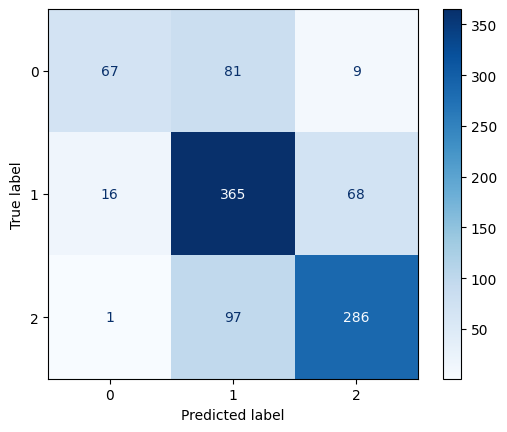

MSE per output: [0.40365096 0.76235996]
RMSE per output: [0.63533531 0.87313227]
MAE per output: [0.49412755 0.71746008]
Precision: 0.7370
Recall:    0.7253
F1 Score:  0.7189
Accuracy:  0.7253


In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mse = mean_squared_error(Y_test_reg, y_reg_pred, multioutput='raw_values')

rmse = np.sqrt(mse)

mae = mean_absolute_error(Y_test_reg, y_reg_pred, multioutput='raw_values')

cm = confusion_matrix(Y_test_class, y_class_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

precision = precision_score(Y_test_class, y_class_pred, average = "weighted")

recall = recall_score(Y_test_class, y_class_pred, average = "weighted")

f1 = f1_score(Y_test_class, y_class_pred, average = "weighted")

accuracy = accuracy_score(Y_test_class, y_class_pred)

print("MSE per output:", mse)

print("RMSE per output:", rmse)

print("MAE per output:", mae)

print(f"Precision: {precision:.4f}")

print(f"Recall:    {recall:.4f}")

print(f"F1 Score:  {f1:.4f}")

print(f"Accuracy:  {accuracy:.4f}")

In [39]:
df_infer = pd.read_csv("trac2_CONVT_test.csv")

columnsInfer = df_infer["text"]
listSentenceInfer = []

for column in columnsInfer:
    listSentenceInfer.append(column)

In [46]:
from google.colab import files
import shutil

folder_to_download = "bert-multitask-final"
output_zip_filename = "bert.zip"

shutil.make_archive(output_zip_filename.replace(".zip", ""), 'zip', folder_to_download)

files.download(output_zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
import torch
import pandas as pd
import torch.nn.functional as F


df_infer = pd.read_csv("trac2_CONVT_test.csv")
ids = df_infer["id"].tolist()
listSentenceInfer = df_infer["text"].tolist()

df_results_infer = outputDataframe(ids, listSentenceInfer)

df_results_infer.to_csv("predictions.csv", index=False)
